In [135]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time

In [136]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [137]:
# Define transformations for the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Load MNIST datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

valid_size = 0.1
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

# Randomly shuffle indices
np.random.shuffle(indices)

# Split indices into training and validation
train_idx, valid_idx = indices[split:], indices[:split]

# Create Subset objects using these indices
train_subset = torch.utils.data.Subset(train_dataset, train_idx)
valid_subset = torch.utils.data.Subset(train_dataset, valid_idx)

# Create data loaders for training and validation sets
batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [138]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.2):
        super(MLP, self).__init__()
        
        # Create a list to hold all layers
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))
        
        # Hidden layers
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        
        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
        # Combine all layers into a sequential model
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        # Flatten the input image
        x = x.view(x.size(0), -1)
        # Forward pass through the network
        return self.model(x)

In [139]:
# Define model parameters
input_size = 28 * 28  # MNIST images are 28x28 pixels
hidden_sizes = [512, 256, 128]  # Three hidden layers
output_size = 10  # 10 classes (digits 0-9)
dropout_rate = 0.2

# Initialize the model
model = MLP(input_size, hidden_sizes, output_size, dropout_rate).to(device)
print(model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)

MLP(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [140]:
# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

# Evaluation function
def evaluate(model, eval_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in eval_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(eval_loader.dataset)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc, all_preds, all_labels

In [141]:
# Training loop
num_epochs = 20
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# For timing measurements
total_training_time = 0
epoch_times = []
overall_start_time = time.time()

for epoch in range(num_epochs):
    # Start timing this epoch
    epoch_start_time = time.time()
    
    # Train
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Evaluate
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Update learning rate
    scheduler.step(test_loss)
    
    # Calculate time taken for this epoch
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    total_training_time += epoch_time
    
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")
    print(f' - Time: {epoch_time:.2f} seconds')
    print('-' * 50)
    print("--------------------------------------------------")
    
# Calculate and print training time statistics
avg_epoch_time = sum(epoch_times) / len(epoch_times)
total_elapsed_time = time.time() - overall_start_time

print("\nTraining Summary:")
print(f"Total Training Time: {total_training_time:.2f} seconds")
print(f"Average Time per Epoch: {avg_epoch_time:.2f} seconds")
print(f"Total Wall Clock Time (including validation): {total_elapsed_time:.2f} seconds")


Epoch 1/20, Train Loss: 1.4144, Train Acc: 0.5805, Test Loss: 0.4643, Test Acc: 0.8735
 - Time: 9.42 seconds
--------------------------------------------------
--------------------------------------------------
Epoch 2/20, Train Loss: 0.4530, Train Acc: 0.8662, Test Loss: 0.3008, Test Acc: 0.9085
 - Time: 7.43 seconds
--------------------------------------------------
--------------------------------------------------
Epoch 3/20, Train Loss: 0.3405, Train Acc: 0.8985, Test Loss: 0.2431, Test Acc: 0.9255
 - Time: 7.51 seconds
--------------------------------------------------
--------------------------------------------------
Epoch 4/20, Train Loss: 0.2794, Train Acc: 0.9182, Test Loss: 0.2054, Test Acc: 0.9370
 - Time: 7.41 seconds
--------------------------------------------------
--------------------------------------------------
Epoch 5/20, Train Loss: 0.2453, Train Acc: 0.9274, Test Loss: 0.1871, Test Acc: 0.9432
 - Time: 8.09 seconds
-----------------------------------------------

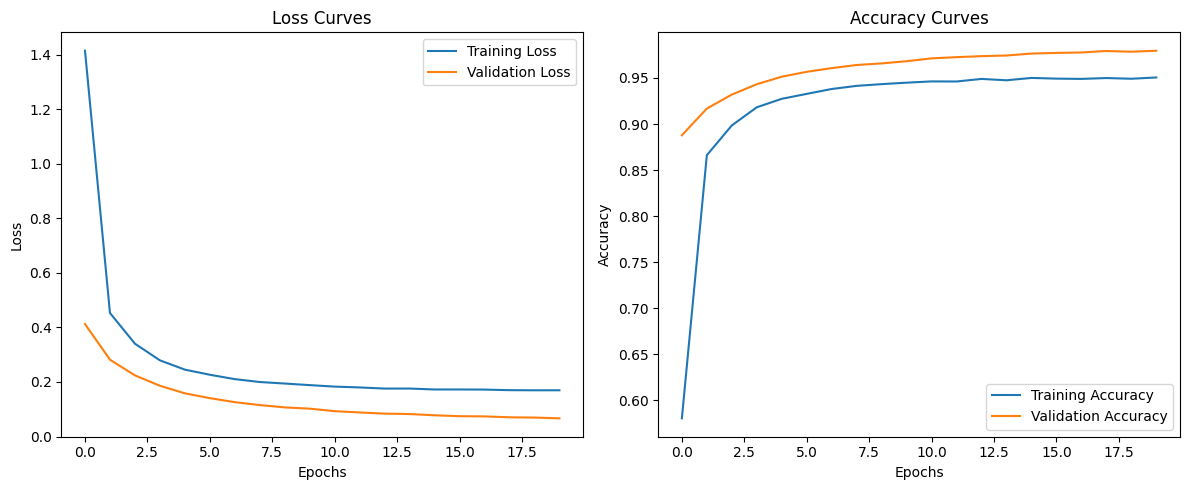

In [142]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.tight_layout()
plt.show()

Final Test Accuracy: 0.9581


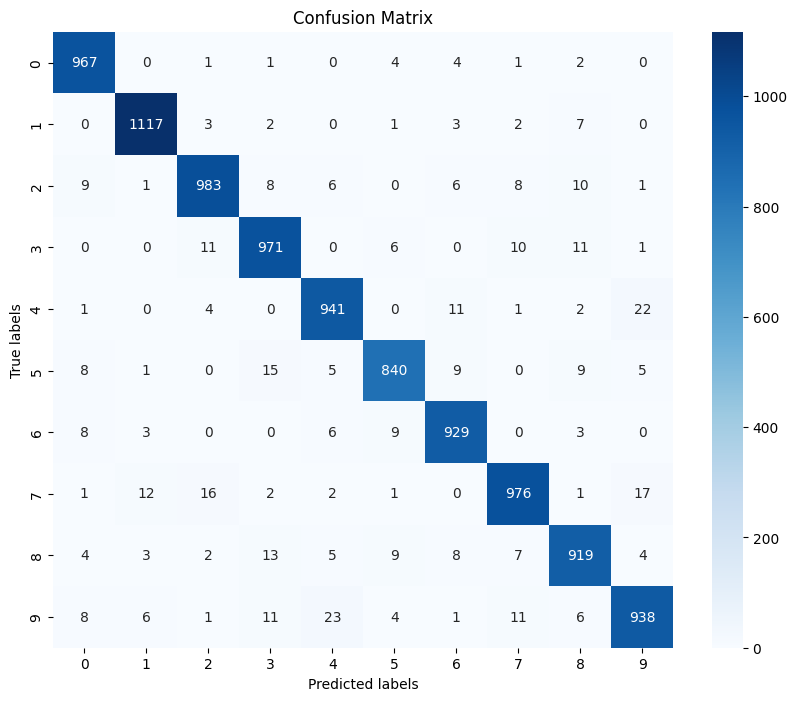

In [143]:
# Final evaluation and confusion matrix
test_loss, test_acc, all_preds, all_labels = evaluate(model, test_loader, criterion, device)
print(f"Final Test Accuracy: {test_acc:.4f}")

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [144]:
def count_parameters(model):
    """Count the total number of trainable parameters in the model"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    # Print parameters by layer
    print("Model Parameters Summary:")
    print("-" * 60)
    print(f"{'Layer':<30} {'Shape':<20} {'Parameters':<10}")
    print("-" * 60)
    
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name:<30} {str(list(param.shape)):<20} {param.numel():<10}")
    
    print("-" * 60)
    print(f"Total Trainable Parameters: {trainable_params:,}")
    print(f"Total Parameters: {total_params:,}")
    
    return trainable_params

# Count parameters in the model
param_count = count_parameters(model)

Model Parameters Summary:
------------------------------------------------------------
Layer                          Shape                Parameters
------------------------------------------------------------
model.0.weight                 [512, 784]           401408    
model.0.bias                   [512]                512       
model.3.weight                 [256, 512]           131072    
model.3.bias                   [256]                256       
model.6.weight                 [128, 256]           32768     
model.6.bias                   [128]                128       
model.9.weight                 [10, 128]            1280      
model.9.bias                   [10]                 10        
------------------------------------------------------------
Total Trainable Parameters: 567,434
Total Parameters: 567,434


In [145]:
def measure_inference_time(model, test_loader, device, num_runs=3):
    model.eval()
    
    # Warm-up run
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            _ = model(images)
    
    # Measure inference time
    inference_times = []
    total_samples = len(test_loader.dataset)
    
    for run in range(num_runs):
        batch_times = []
        
        with torch.no_grad():
            for images, _ in test_loader:
                images = images.to(device)
                
                # Measure batch inference time
                start_time = time.time()
                _ = model(images)
                end_time = time.time()
                
                batch_times.append(end_time - start_time)
        
        total_run_time = sum(batch_times)
        inference_times.append(total_run_time)
        print(f"Run {run+1}: {total_run_time:.4f} seconds")
    
    # Calculate statistics
    avg_inference_time = sum(inference_times) / len(inference_times)
    samples_per_second = total_samples / avg_inference_time
    ms_per_sample = (avg_inference_time * 1000) / total_samples
    
    print("\nInference Time Measurements:")
    print(f"  Test Dataset Size: {total_samples} samples")
    print(f"  Average Inference Time (over {num_runs} runs): {avg_inference_time:.4f}s")
    print(f"  Throughput: {samples_per_second:.2f} samples/second")
    print(f"  Latency: {ms_per_sample:.4f} ms/sample")
    
    return avg_inference_time

# Final evaluation on test set
print("\nFinal Evaluation on Test Set:")
test_loss, test_accuracy, _, _ = evaluate(model, test_loader, criterion, device)
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Measure inference time on test set
inference_time = measure_inference_time(model, test_loader, device)



Final Evaluation on Test Set:
Test Accuracy: 0.96%
Test Loss: 0.1348
Run 1: 0.0674 seconds
Run 2: 0.0926 seconds
Run 3: 0.0756 seconds

Inference Time Measurements:
  Test Dataset Size: 10000 samples
  Average Inference Time (over 3 runs): 0.0786s
  Throughput: 127271.62 samples/second
  Latency: 0.0079 ms/sample
